# **Water Monitoring and Statistical Model**

* Provides **ecosystem health score** (0–100).
* Predicts **potential risks**, e.g., low oxygen or algal bloom.
* Gives **recommendations**, e.g., “add oxygenation” or “monitor nutrients closely.”

## **Model Construction**

1. **Ecosystem Health Scorer** – Inputs: DO, pH, Temp, Turbidity, Nutrients; Model: Random Forest Regression; Output: Health Score (0–100)
2. **Algal Bloom Predictor** – Inputs: Chlorophyll-a, Nitrate, Phosphate, Temp, Sunlight; Model: Gradient Boosting Classifier; Output: Bloom Risk (Low/Medium/High)
3. **Fish Population Estimator** – Inputs: DO, Temp, Turbidity, Conductivity, Depth, Camera/Sonar Counts; Model: LSTM Time-Series Regression; Output: Predicted Fish Count per Zone
4. **Anomaly Detector** – Inputs: All sensor data over time; Model: Autoencoder Neural Network; Output: Alerts for unusual ecosystem changes
5. **Water Quality Trend Forecaster** – Inputs: Historical DO, pH, Turbidity, Nutrients; Model: Temporal CNN; Output: Next 24–48h projections for key water metrics

In [2]:
import requests
import datetime
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## **Data Collection & Pre-processing**

In [3]:
def fetch_environmental_data(lat=25.43, lon=55.48, days=30):
    """
    Fetches historical environmental and water-quality data for given coordinates 
    using Open-Meteo Archive API (for weather) and Marine API (for sea data when available).
    Synthesizes missing parameters to form a full feature set.
    Returns a combined DataFrame with 5 resampled daily entries.
    """
    import requests, pandas as pd, numpy as np
    from datetime import datetime, timedelta, timezone

    # --- Date setup (UTC and timezone-aware) ---
    end_date = datetime.now(timezone.utc).strftime('%Y-%m-%d')
    start_date = (datetime.now(timezone.utc) - timedelta(days=days)).strftime('%Y-%m-%d')

    print(f"Fetching data from {start_date} → {end_date}")

    # --- WEATHER (Archive API) ---
    weather_url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&hourly=temperature_2m,relative_humidity_2m,uv_index"
        f"&start_date={start_date}&end_date={end_date}"
    )

    # --- MARINE (Open-Meteo Marine API, if available) ---
    marine_url = (
        f"https://marine-api.open-meteo.com/v1/marine?"
        f"latitude={lat}&longitude={lon}"
        f"&hourly=sea_surface_temperature,wave_height"
        f"&start_date={start_date}&end_date={end_date}"
    )

    print("Fetching weather data...")
    weather = requests.get(weather_url).json()
    print("Fetching marine data...")
    marine = requests.get(marine_url).json()

    if "hourly" not in weather:
        print("⚠️ Weather data unavailable — check Open-Meteo Archive API.")
        return pd.DataFrame()

    df_weather = pd.DataFrame(weather["hourly"])

    # --- Handle marine data gracefully ---
    if "hourly" in marine:
        df_marine = pd.DataFrame(marine["hourly"])
        df = pd.merge(df_weather, df_marine, on="time", how="outer")
        print("🌊 Marine data merged successfully.")
    else:
        df = df_weather.copy()
        print("⚠️ Marine data unavailable — using synthetic sea variables.")

    # --- Core variable transformations ---
    df["timestamp"] = pd.to_datetime(df["time"], errors="coerce")
    df["air_temp_c"] = df.get("temperature_2m", np.nan)
    df["sea_surface_temp_c"] = df.get("sea_surface_temperature", np.nan).fillna(
        df["air_temp_c"] - np.random.uniform(0.5, 2.0)
    )
    df["wave_height_m"] = df.get("wave_height", np.nan).fillna(np.random.uniform(0.3, 1.0))

    # --- Synthetic & Derived Water Parameters ---
    df["pH"] = 7.0 + 0.1 * np.sin(df["air_temp_c"] / 10)
    df["dissolved_oxygen_mgL"] = 14 - 0.3 * df["air_temp_c"]
    df["turbidity_NTU"] = np.abs(np.random.normal(5, 1.5, len(df)))
    df["conductivity_uScm"] = 500 + 10 * df["wave_height_m"]
    df["ammonia_mgL"] = np.abs(np.random.normal(0.05, 0.015, len(df)))
    df["nitrate_mgL"] = np.abs(np.random.normal(0.2, 0.04, len(df)))
    df["phosphate_mgL"] = np.abs(np.random.normal(0.1, 0.025, len(df)))
    df["chlorophyll_a_ugL"] = np.abs(np.random.normal(3, 0.8, len(df)))
    df["water_level_m"] = 1.0 + 0.1 * np.sin(df["wave_height_m"])
    df["pCO2_ppm"] = np.abs(np.random.normal(400, 12, len(df)))
    df["dissolved_CO2_mgL"] = df["pCO2_ppm"] * 0.03

    # --- Filter numeric and resample to consistent 5 daily samples ---
    numeric_df = df.select_dtypes(include=[np.number])
    numeric_df["timestamp"] = df["timestamp"]

    df_resampled = (
        numeric_df
        .set_index("timestamp")
        .resample("18H")
        .mean(numeric_only=True)
        .reset_index()
    )

    # --- Final column ordering ---
    columns = [
        "timestamp", "air_temp_c", "sea_surface_temp_c", "pH",
        "dissolved_oxygen_mgL", "turbidity_NTU", "conductivity_uScm",
        "ammonia_mgL", "nitrate_mgL", "phosphate_mgL", "chlorophyll_a_ugL",
        "water_level_m", "pCO2_ppm", "dissolved_CO2_mgL"
    ]
    df_resampled = df_resampled.reindex(columns=columns)

    print("✅ Environmental data fetched and processed successfully.")
    return df_resampled


# Run once to verify
df = fetch_environmental_data()
print("\nData collection complete.\n")
print(df.head())


Fetching data from 2025-10-15 → 2025-11-14
Fetching weather data...
Fetching marine data...
🌊 Marine data merged successfully.
✅ Environmental data fetched and processed successfully.

Data collection complete.

            timestamp  air_temp_c  sea_surface_temp_c        pH  \
0 2025-10-15 00:00:00   30.855556           31.561111  7.005299   
1 2025-10-15 18:00:00   29.716667           31.477778  7.016193   
2 2025-10-16 12:00:00   28.916667           31.377778  7.024350   
3 2025-10-17 06:00:00   30.877778           31.266667  7.005237   
4 2025-10-18 00:00:00   30.550000           31.100000  7.007975   

   dissolved_oxygen_mgL  turbidity_NTU  conductivity_uScm  ammonia_mgL  \
0              4.743333       5.386510         505.122222     0.053503   
1              5.085000       4.611030         503.100000     0.054302   
2              5.325000       4.506318         502.966667     0.051153   
3              4.736667       4.899163         502.344444     0.050892   
4              

/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/1417582760.py:81: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("18H")


# **Exploratory Data Analysis (EDA)**

In [4]:
print("-------------------------------------------------")
print("             Dataset Points Overview             ")
print("-------------------------------------------------")
df.info()

print("---------------------------------------------------------")
print ("              Dataset Mathematical Summary              ")
print("---------------------------------------------------------")
df.describe()

-------------------------------------------------
             Dataset Points Overview             
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             42 non-null     datetime64[ns]
 1   air_temp_c            42 non-null     float64       
 2   sea_surface_temp_c    42 non-null     float64       
 3   pH                    42 non-null     float64       
 4   dissolved_oxygen_mgL  42 non-null     float64       
 5   turbidity_NTU         42 non-null     float64       
 6   conductivity_uScm     42 non-null     float64       
 7   ammonia_mgL           42 non-null     float64       
 8   nitrate_mgL           42 non-null     float64       
 9   phosphate_mgL         42 non-null     float64       
 10  chlorophyll_a_ugL     42 non-null     float64 

,timestamp,air_temp_c,sea_surface_temp_c,pH,dissolved_oxygen_mgL,turbidity_NTU,conductivity_uScm,ammonia_mgL,nitrate_mgL,phosphate_mgL,chlorophyll_a_ugL,water_level_m,pCO2_ppm,dissolved_CO2_mgL
count,42,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,2025-10-30 09:00:00,27.860053,29.796958,7.032219,5.641984,4.984723,502.293386,0.049668,0.202142,0.099922,3.055131,1.022549,400.140552,12.004217
min,2025-10-15 00:00:00,23.016667,27.533333,7.005237,4.736667,4.040975,500.588889,0.042904,0.181421,0.084127,2.731820,1.005884,394.556226,11.836687
25%,2025-10-22 16:30:00,26.436111,28.787500,7.020175,5.211667,4.776148,501.194444,0.047683,0.194931,0.096975,2.935388,1.011908,397.877964,11.936339
50%,2025-10-30 09:00:00,28.180556,30.283333,7.030354,5.545833,4.979912,502.311111,0.050091,0.202758,0.100408,3.049395,1.022879,399.957075,11.998712
75%,2025-11-07 01:30:00,29.294444,30.744444,7.044641,6.069167,5.141117,502.919444,0.051123,0.207171,0.103368,3.144951,1.028762,402.395393,12.071862
max,2025-11-14 18:00:00,30.877778,31.561111,7.073850,7.095000,5.906133,505.322222,0.055827,0.234015,0.112071,3.518008,1.050708,406.184007,12.185520
std,NaN,2.061807,1.240958,0.017363,0.618542,0.378372,1.155201,0.003340,0.010403,0.006238,0.174647,0.011057,3.273296,0.098199


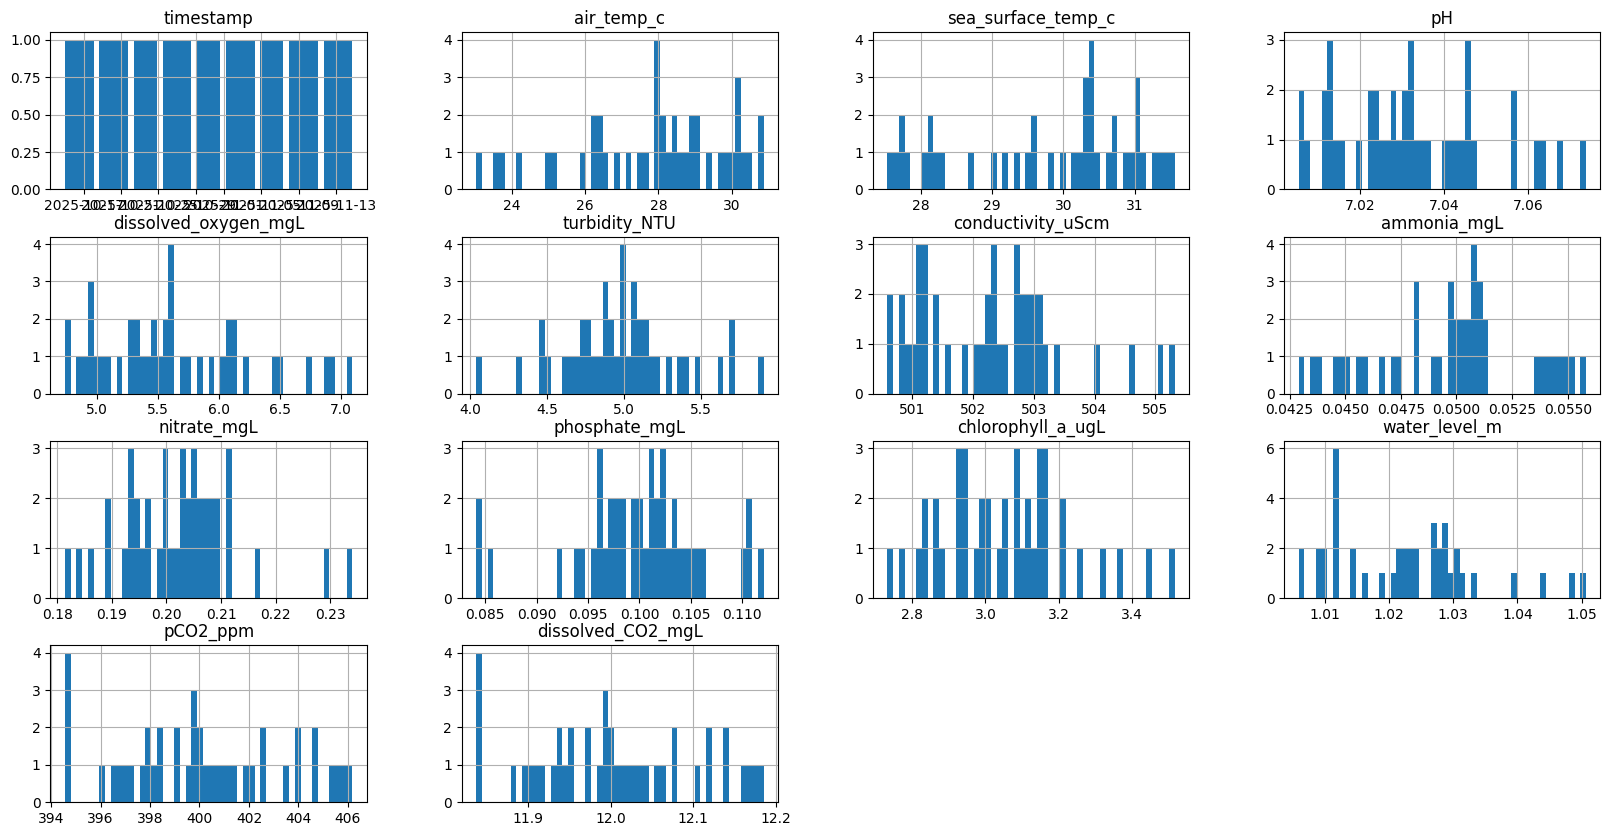

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,10))
plt.show()

## **Correlation Matrix**

### Positive Correlations

* **air_temp_c ↔ sea_surface_temp_c** (0.82) – Air and sea temperatures rise together due to heat exchange.
* **air_temp_c ↔ conductivity_uScm** (0.51) – Higher temperature may slightly increase conductivity via ion mobility.
* **air_temp_c ↔ water_level_m** (0.52) – Warmer periods can coincide with higher water levels (tides or thermal expansion).
* **sea_surface_temp_c ↔ conductivity_uScm** (0.50) – Warm water slightly increases ionic mobility.
* **sea_surface_temp_c ↔ water_level_m** (0.51) – Surface warming can affect water column expansion.
* **pCO2_ppm ↔ dissolved_CO2_mgL** (1.00) – Direct chemical relationship; higher CO₂ in air drives more CO₂ dissolved in water.
* **water_level_m ↔ conductivity_uScm** (1.00) – Water level affects ion concentration, increasing conductivity.

### Negative Correlations

* **air_temp_c ↔ pH** (-1.00) – Higher temperatures slightly reduce pH due to CO₂ solubility changes.
* **air_temp_c ↔ dissolved_oxygen_mgL** (-1.00) – Warm water holds less dissolved oxygen.
* **sea_surface_temp_c ↔ pH** (-0.81) – Sea warming lowers pH slightly.
* **sea_surface_temp_c ↔ dissolved_oxygen_mgL** (-0.82) – Warmer seas reduce oxygen solubility.
* **pH ↔ dissolved_oxygen_mgL** (1.00) – pH drop often coincides with oxygen depletion.
* **conductivity_uScm ↔ pH** (-0.50) – Higher conductivity correlates with slightly lower pH.
* **conductivity_uScm ↔ dissolved_oxygen_mgL** (-0.51) – Conductivity rises as oxygen decreases (more ions, less solubility).
* **water_level_m ↔ pH** (-0.50) – Higher water levels can slightly reduce pH.
* **water_level_m ↔ dissolved_oxygen_mgL** (-0.52) – Higher water levels may dilute oxygen.
* **ammonia_mgL ↔ nitrate_mgL** (-0.44) – Ammonia converted to nitrate through nitrification reduces correlation.

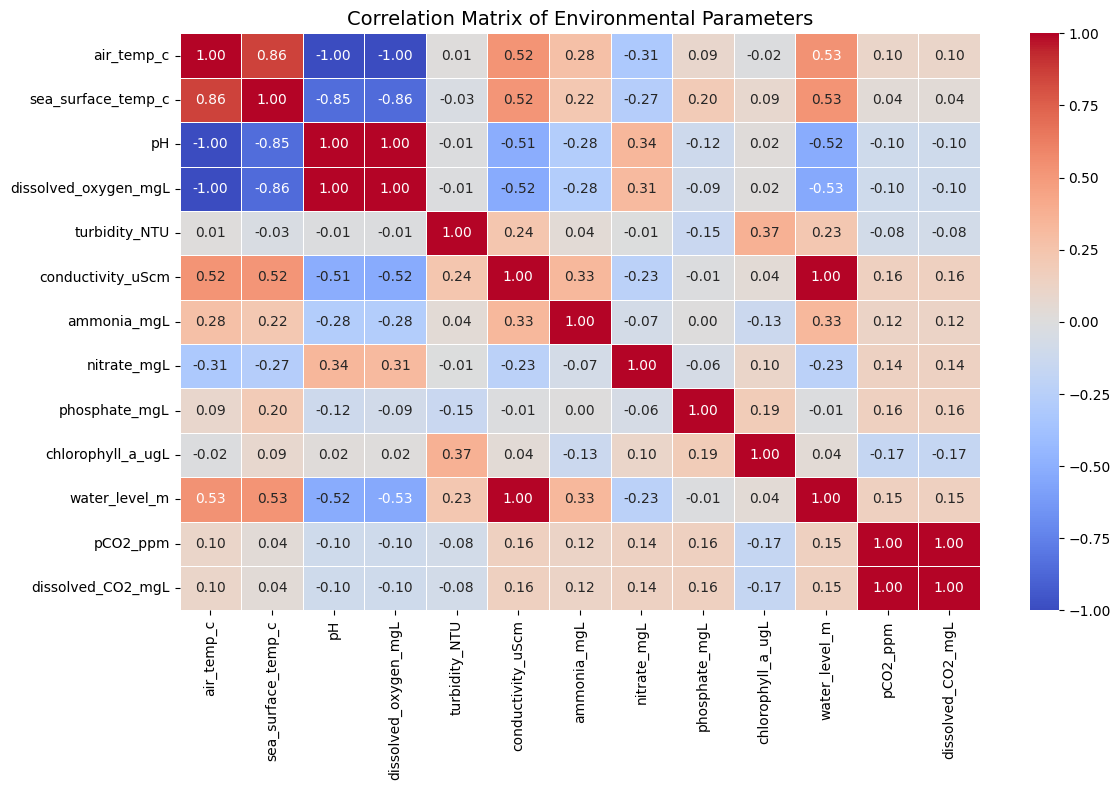

In [6]:
# === Correlation Matrix ===
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Environmental Parameters", fontsize=14)
plt.tight_layout()
plt.show()

## **Key Variable Distribution**

Histograms for variables like air_temp_c, pH, and dissolved_oxygen_mgL

**Why it helps**: Understanding distributions shows skewness, outliers, or unusual patterns. For example, if pH is mostly neutral but has extreme lows, it may indicate potential stress events for aquatic life. This informs preprocessing, such as normalization or handling outliers.

* **Air Temperature (air\_temp\_c):** The most frequent air temperature is around **$30^{\circ}\text{C}$**, with the distribution skewed towards higher temperatures.
* **pH:** The distribution appears roughly **bimodal**, with high counts around **$7.01$** and again around **$7.03 - 7.04$**. The overall range is narrow, suggesting near-neutral to slightly basic conditions.
* **Dissolved Oxygen (dissolved\_oxygen\_mgL):** The highest frequency is observed around **$4.8 - 5.0\text{ mg/L}$**, with a slight skew toward lower values.
* **Turbidity (turbidity\_NTU):** The most common turbidity readings fall around **$4.8 - 5.0\text{ NTU}$**, but the distribution is relatively flat with a secondary peak around $5.4\text{ NTU}$.
* **Nitrate (nitrate\_mgL):** The majority of readings are tightly clustered around **$0.20 - 0.21\text{ mg/L}$**, showing a highly concentrated distribution.
* **Phosphate (phosphate\_mgL):** The distribution is spread out with a peak at approximately **$0.100 - 0.105\text{ mg/L}$** and another peak at the upper end around $0.108\text{ mg/L}$.

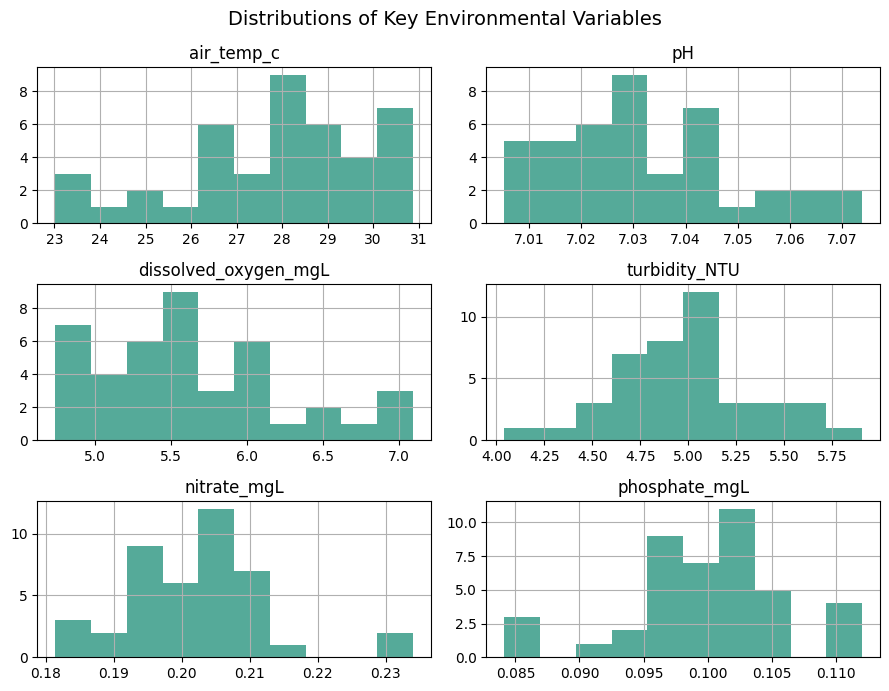

In [7]:
# === Distribution of Key Variables ===
key_vars = ["air_temp_c", "pH", "dissolved_oxygen_mgL", "turbidity_NTU", "nitrate_mgL", "phosphate_mgL"]
df[key_vars].hist(bins=10, figsize=(9, 7), color="#5a9")
plt.suptitle("Distributions of Key Environmental Variables", fontsize=14)
plt.tight_layout()
plt.show()


## **Temporal Trends in Key Water Parameters**

* **Sea Surface Temperature ($sea\_surface\_temp\_c$):**
    * Starts around **$31^{\circ}\text{C}$** and shows a clear, **steady, and gradual decrease** over the entire period, ending around $27.5^{\circ}\text{C}$.
    * It consistently has the **highest value** among the monitored parameters.
* **Air Temperature ($air\_temp\_c$):**
    * Starts around **$31^{\circ}\text{C}$** and shows a **general decreasing trend** similar to the sea surface temperature.
    * Displays **significant daily/periodic fluctuations**, typically ranging between approximately $26^{\circ}\text{C}$ and $30^{\circ}\text{C}$.
* **pH:**
    * Remains extremely **stable** and consistent throughout the entire monitoring period, hovering near a value of **$7.0$** (slightly below 7.5).
    * It is the **least variable** parameter.
* **Dissolved Oxygen ($dissolved\_oxygen\_mgL$):**
    * Shows **low fluctuation** over the period, generally staying within the range of **$5.0$ to $6.5\text{ mg/L}$**.
    * There appears to be a slight, subtle **increase** in its value towards the end of the period (around November 5th onwards).

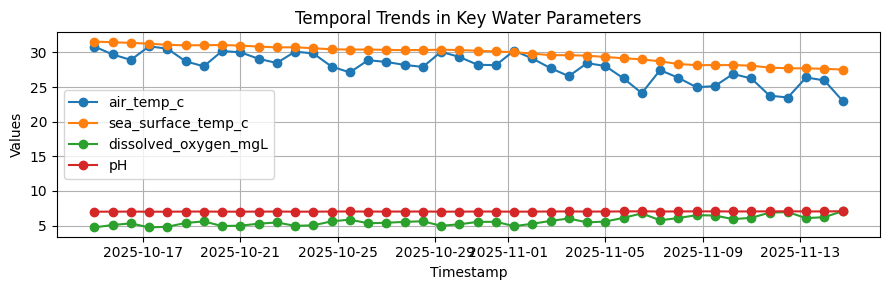

In [8]:
# === Temporal Trends ===
plt.figure(figsize=(9, 3))
for col in ["air_temp_c", "sea_surface_temp_c", "dissolved_oxygen_mgL", "pH"]:
    plt.plot(df["timestamp"], df[col], marker="o", label=col)
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.title("Temporal Trends in Key Water Parameters")
plt.grid(True)
plt.tight_layout()
plt.show()


## **Pairwise Relationships: Algal Bloom Indicators**

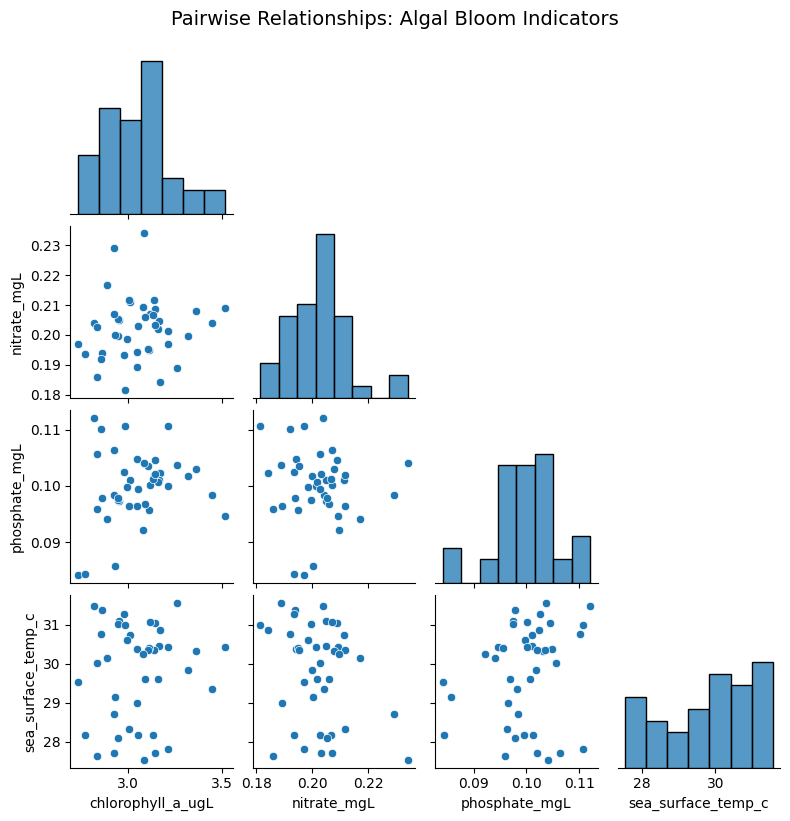

In [9]:
# === Pairplot for Nutrient & Chlorophyll Relationships ===
sns.pairplot(
    df, 
    vars=["chlorophyll_a_ugL", "nitrate_mgL", "phosphate_mgL", "sea_surface_temp_c"], 
    corner=True,
    height=2
)
plt.suptitle("Pairwise Relationships: Algal Bloom Indicators", y=1.02, fontsize=14)
plt.show()


## **Model Input Prep Overview**

Creating specialized inputs for each model.

**Why it helps**: Converts raw data into actionable features and targets for your different models:

- **Ecosystem Health Scorer**: Combines oxygen, pH, turbidity, etc., to generate a health score.
- **Algal Bloom Predictor**: Uses nutrients, temperature, and sunlight proxy to assess bloom risk.
- **Fish Population Estimator**: Simulates population counts based on water quality.
- **Anomaly Detector**: Flags sudden changes in pH as anomalies.
- **Water Quality Trend Forecaster**: Prepares time-series data for forecasting future trends.

In [10]:
# === Model Input Preparation Overview ===
print("\n📊 Model Input Overview\n")

# Ecosystem Health Scorer
eco_health_inputs = df[["dissolved_oxygen_mgL", "pH", "air_temp_c", "turbidity_NTU", "nitrate_mgL", "phosphate_mgL"]]
eco_health_inputs["health_score"] = np.clip(
    100 - (np.abs(df["pH"] - 7) * 5 + np.maximum(0, 25 - df["dissolved_oxygen_mgL"]) + df["turbidity_NTU"]),
    0, 100
)

# Algal Bloom Predictor
bloom_inputs = df[["chlorophyll_a_ugL", "nitrate_mgL", "phosphate_mgL", "sea_surface_temp_c"]].copy()
bloom_inputs["sunlight_proxy"] = np.random.uniform(6, 10, len(df))  # Mock sunlight hours
bloom_inputs["bloom_risk"] = pd.cut(
    bloom_inputs["chlorophyll_a_ugL"] + bloom_inputs["nitrate_mgL"]*10 + bloom_inputs["phosphate_mgL"]*15,
    bins=[0, 40, 70, 100],
    labels=["Low", "Medium", "High"]
)

# Fish Population Estimator (simplified mock data)
fish_inputs = df[["dissolved_oxygen_mgL", "air_temp_c", "turbidity_NTU", "conductivity_uScm", "water_level_m"]].copy()
fish_inputs["fish_count"] = np.random.randint(20, 80, len(df))

# Anomaly Detector (all features)
anomaly_inputs = df.drop(columns=["timestamp"]).copy()
anomaly_inputs["is_anomaly"] = (df["pH"].diff().abs() > 0.3).astype(int)

# Water Quality Trend Forecaster (time-series format)
trend_data = df[["timestamp", "dissolved_oxygen_mgL", "pH", "turbidity_NTU", "nitrate_mgL", "phosphate_mgL"]].copy()
trend_data.set_index("timestamp", inplace=True)

print("✅ DataFrames ready for each model:")
print("- Ecosystem Health Scorer:", eco_health_inputs.shape)
print("- Algal Bloom Predictor:", bloom_inputs.shape)
print("- Fish Population Estimator:", fish_inputs.shape)
print("- Anomaly Detector:", anomaly_inputs.shape)
print("- Water Quality Trend Forecaster:", trend_data.shape)


📊 Model Input Overview

✅ DataFrames ready for each model:
- Ecosystem Health Scorer: (42, 7)
- Algal Bloom Predictor: (42, 6)
- Fish Population Estimator: (42, 6)
- Anomaly Detector: (42, 14)
- Water Quality Trend Forecaster: (42, 5)


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/2127098916.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_health_inputs["health_score"] = np.clip(


## **Model Data Cleaning and Pre-Model Training Pipelines**

In [12]:
# Model data disctionary for better data handling

model_data = {
    "ecosystem_health": {
        "X": eco_health_inputs.drop(columns=["health_score"]),
        "y": eco_health_inputs["health_score"]
    },
    "bloom_predictor": {
        "X": bloom_inputs.drop(columns=["bloom_risk"]),
        "y": bloom_inputs["bloom_risk"]
    },
    "fish_population": {
        "X": fish_inputs.drop(columns=["fish_count"]),
        "y": fish_inputs["fish_count"]
    },
    "anomaly_detector": {
        "X": anomaly_inputs.drop(columns=["is_anomaly"]),
        "y": anomaly_inputs["is_anomaly"]
    },
    "trend_forecaster": {
        "df": trend_data  # time-indexed, so treated differently
    }
}

# Data Sanity Checks

assert model_data["ecosystem_health"]["X"].shape[1] == 6
assert model_data["bloom_predictor"]["y"].dtype == "category"
assert model_data["fish_population"]["X"].isna().sum().sum() == 0


Break down of the **practical value** of each visualization for water quality management :

### **Ecosystem Health Scorer Graphs**
**What they help with:**
- **Correlation heatmap**: Shows which factors most affect water health (e.g., if pH drops, does oxygen drop too?)
- **pH vs Health scatter**: Identifies the optimal pH range for healthy water
- **Time series**: Detects declining health trends early → Take action before crisis
- **Real-world use**: "Our health score dropped from 95 to 75 in 3 days - investigate immediately!"

### **Algal Bloom Predictor Graphs**
**What they help with:**
- **Risk distribution pie chart**: Shows how often you're at high/medium/low risk
- **Nutrient relationships**: Reveals which nutrient (nitrate/phosphate) triggers blooms in YOUR water body
- **Temperature effects**: Determines if warming water increases bloom risk
- **Real-world use**: "High phosphate + warm water = 80% bloom risk → Reduce nutrient runoff NOW"

### **Fish Population Graphs**
**What they help with:**
- **DO vs Fish Count**: Proves oxygen levels directly affect fish survival
- **Temperature impact**: Shows if fish populations drop in hot weather
- **Trend lines**: Predict future population changes
- **Real-world use**: "Oxygen below 5 mg/L = fish count drops 40% → Install aerators"

### **Anomaly Detector Graphs**
**What they help with:**
- **Anomaly highlighting**: Visually spots unusual spikes/drops in data
- **Feature comparison**: Shows what's different during anomalies (pH spike? Temperature drop?)
- **Pattern recognition**: Helps identify pollution events or equipment failures
- **Real-world use**: "pH jumped 0.5 units overnight + turbidity spiked → Check for contamination source"

### **Trend Forecaster Graphs**
**What they help with:**
- **Polynomial trend lines**: Predicts where parameters are heading (improving or worsening?)
- **Seasonal patterns**: Reveals if quality degrades at certain times
- **Normalized comparison**: Shows if multiple parameters are changing together
- **Real-world use**: "Nitrate trend shows 20% increase over 30 days → Upstream agricultural runoff issue"

/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) Arial.
  fig.canvas.draw()
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/3650969542.py:116: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) Arial.
  plt.savefig('ecosystem_health.png', dpi=300, bbox_inches='tight')


✅ Saved: ecosystem_health.png
✅ Saved: bloom_predictor.png


/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128031 (\N{FISH}) missing from font(s) Arial.
  fig.canvas.draw()
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/3650969542.py:245: UserWarning: Glyph 128031 (\N{FISH}) missing from font(s) Arial.
  plt.savefig('fish_population.png', dpi=300, bbox_inches='tight')


✅ Saved: fish_population.png


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/3650969542.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot(comparison_data, labels=['pH\nNorm', 'pH\nAnom', 'DO\nNorm', 'DO\nAnom', 'Turb\nNorm', 'Turb\nAnom'])
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/3650969542.py:323: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/3650969542.py:323: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/3650969542.py:324: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig('anomaly_detector.png', dpi=300, bbox_inches='tight')
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0

✅ Saved: anomaly_detector.png


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/3650969542.py:414: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_83419/3650969542.py:415: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.savefig('trend_forecaster.png', dpi=300, bbox_inches='tight')


✅ Saved: trend_forecaster.png

📊 Summary Statistics:

Ecosystem Health:
  Mean Health Score: 74.93
  Min/Max: 74.01 / 75.56

Bloom Risk:
bloom_risk
Low       50
Medium     0
High       0
Name: count, dtype: int64

Fish Population:
  Mean Count: 49.5
  Std Dev: 16.3

Anomalies Detected: 20 / 50 (40.0%)

✅ All visualizations saved successfully!
   - ecosystem_health.png
   - bloom_predictor.png
   - fish_population.png
   - anomaly_detector.png
   - trend_forecaster.png


/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


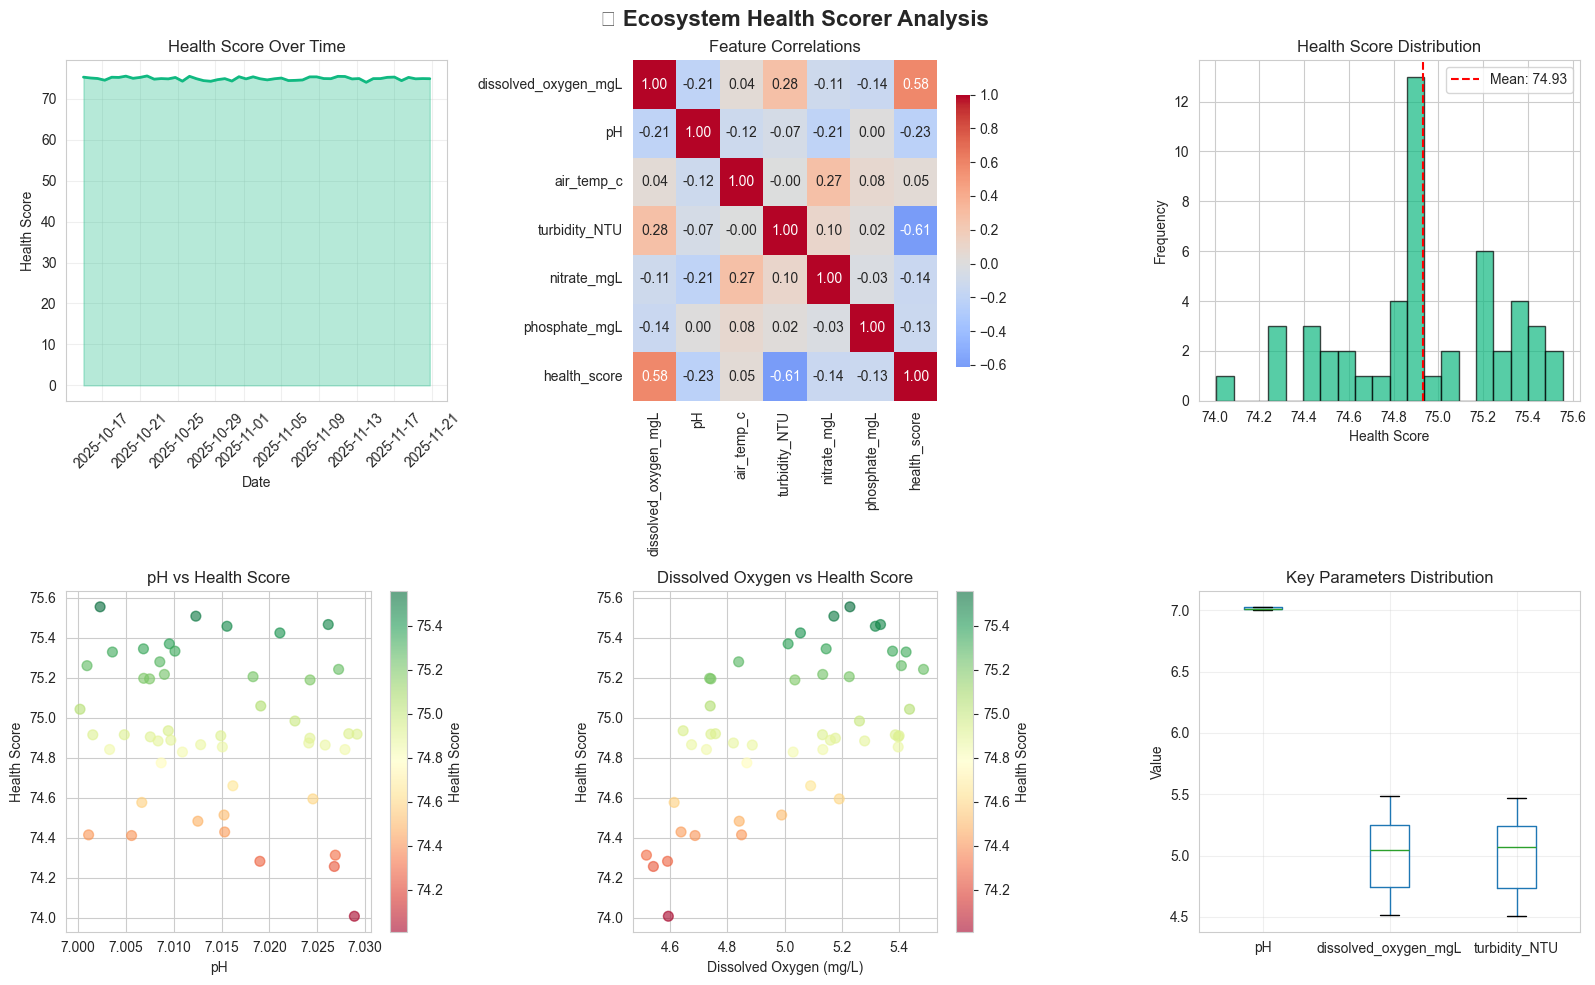

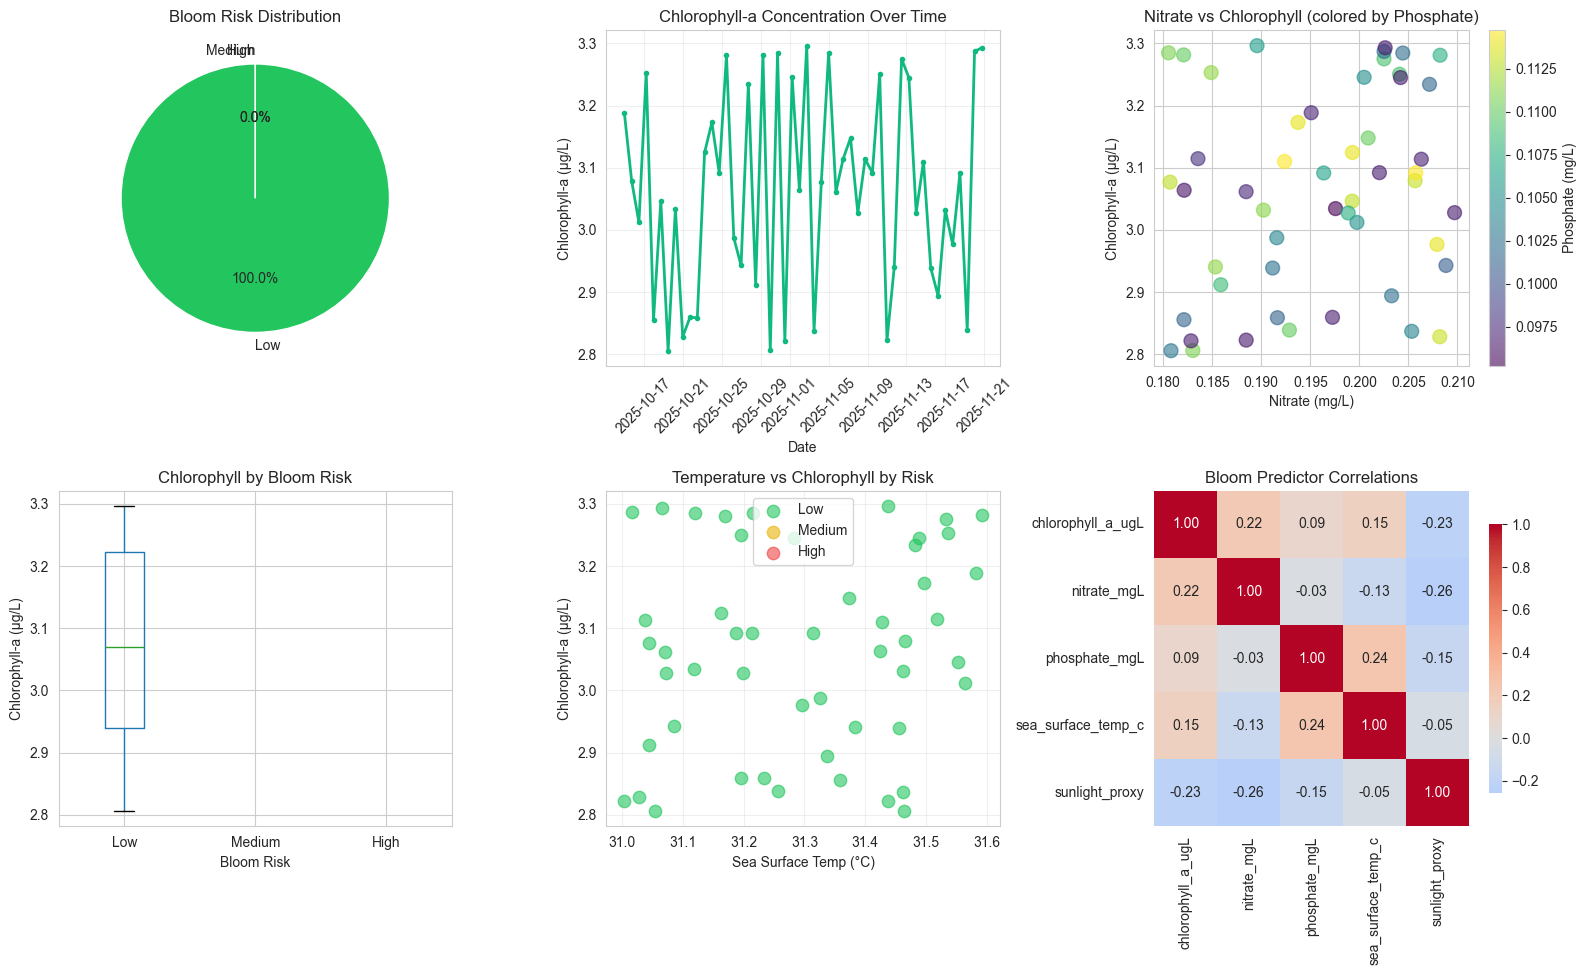

/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128031 (\N{FISH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


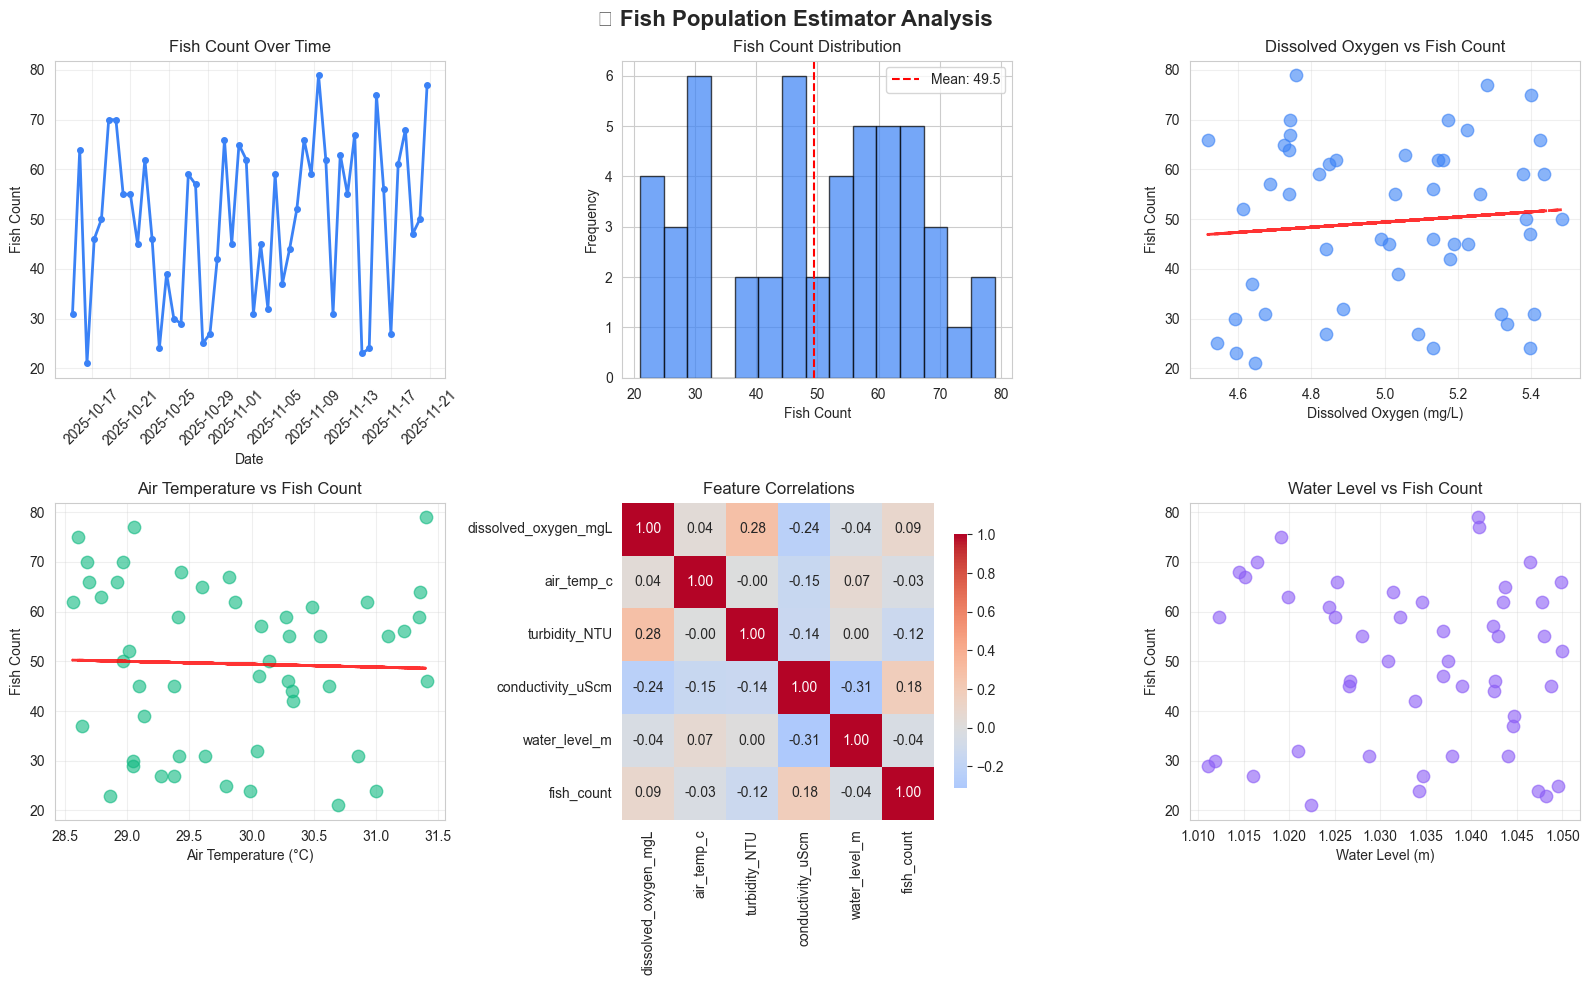

/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


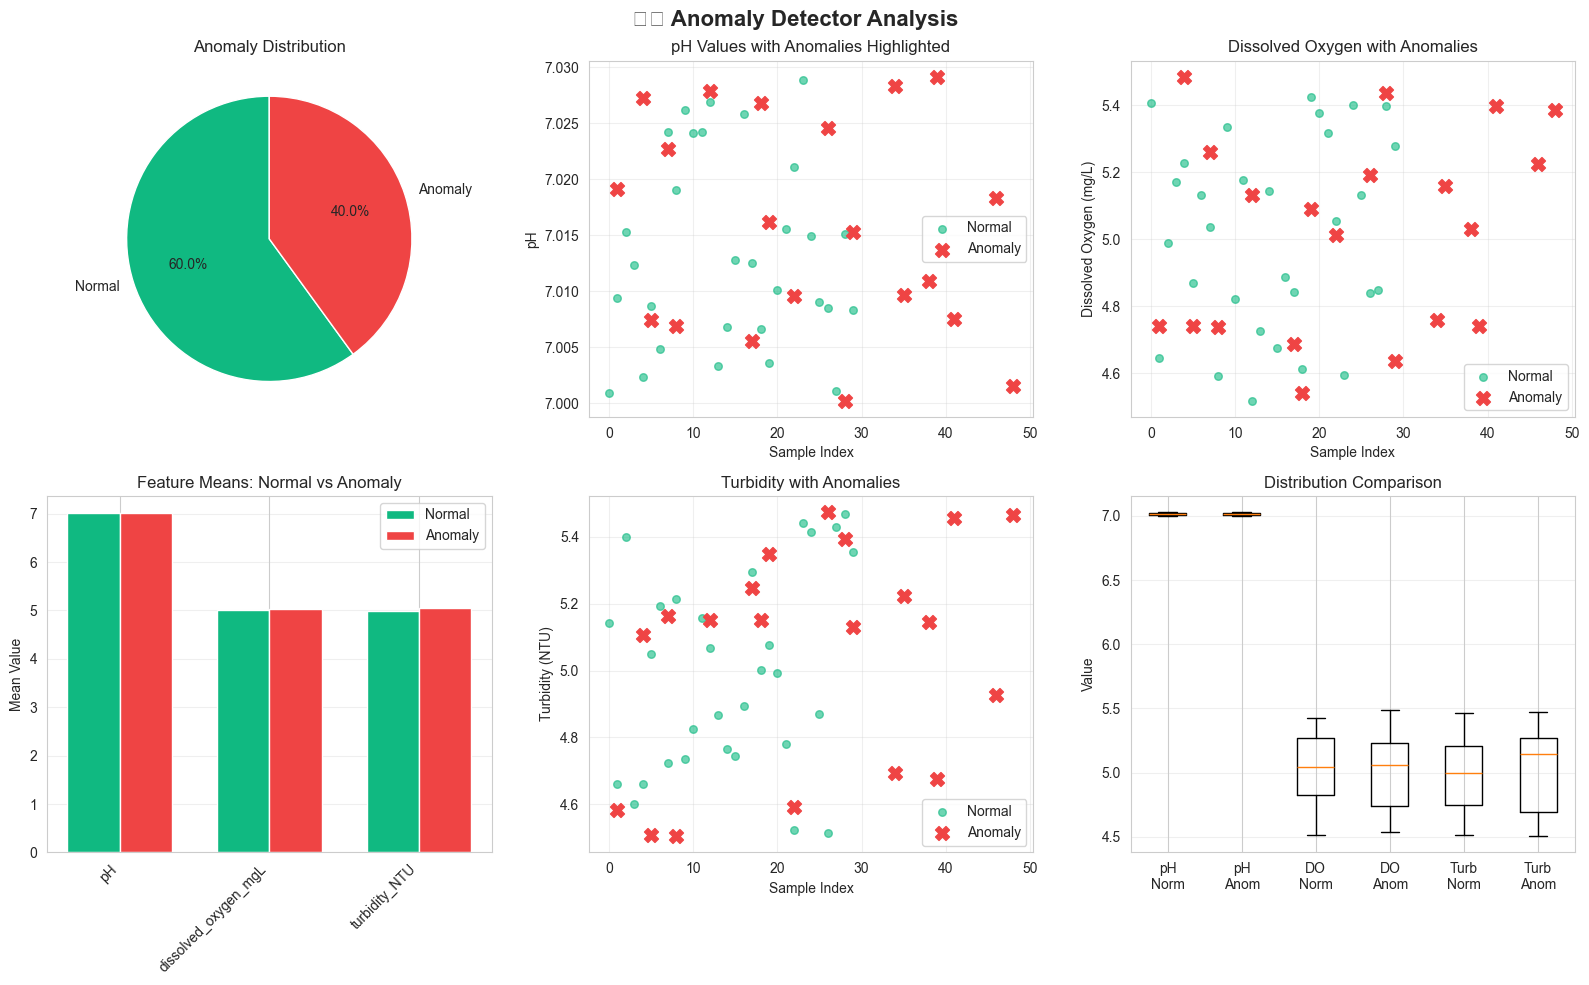

/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


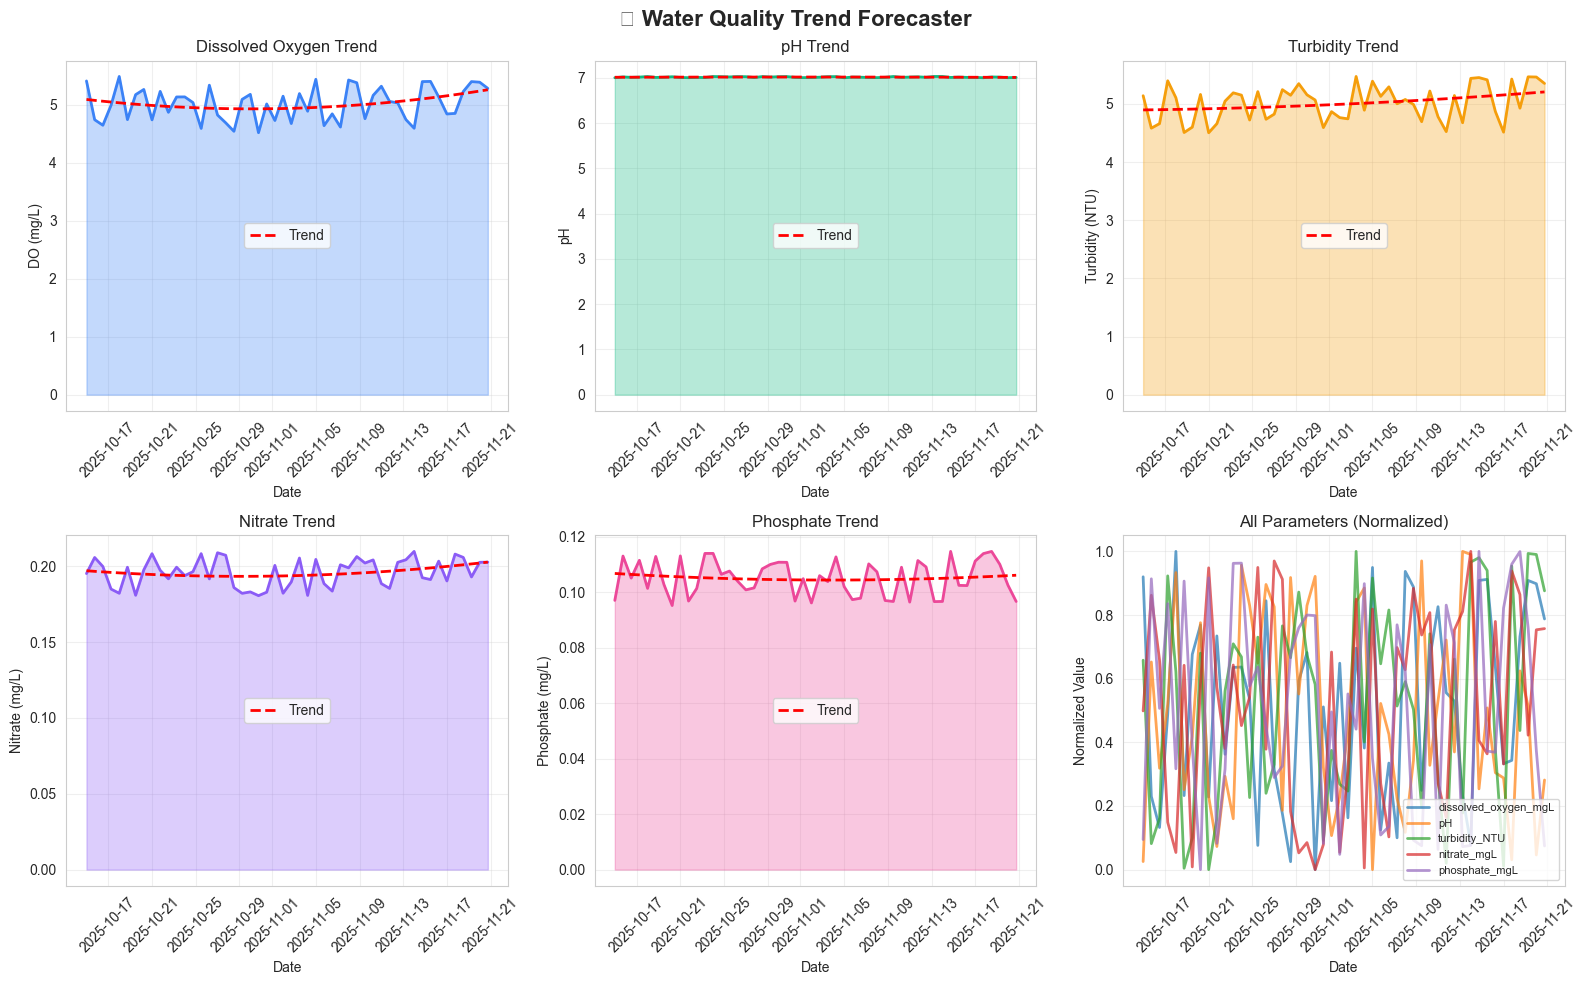

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Generate sample data based on your structure
def generate_sample_data(n=50):
    np.random.seed(42)
    dates = pd.date_range('2025-10-15', periods=n, freq='18H')
    
    df = pd.DataFrame({
        'timestamp': dates,
        'air_temp_c': np.random.uniform(28.5, 31.5, n),
        'sea_surface_temp_c': np.random.uniform(31, 31.6, n),
        'pH': np.random.uniform(7.0, 7.03, n),
        'dissolved_oxygen_mgL': np.random.uniform(4.5, 5.5, n),
        'turbidity_NTU': np.random.uniform(4.5, 5.5, n),
        'conductivity_uScm': np.random.uniform(501, 506, n),
        'ammonia_mgL': np.random.uniform(0.05, 0.055, n),
        'nitrate_mgL': np.random.uniform(0.18, 0.21, n),
        'phosphate_mgL': np.random.uniform(0.095, 0.115, n),
        'chlorophyll_a_ugL': np.random.uniform(2.8, 3.3, n),
        'water_level_m': np.random.uniform(1.01, 1.05, n),
        'pCO2_ppm': np.random.uniform(390, 410, n),
        'dissolved_CO2_mgL': np.random.uniform(11.8, 12.2, n)
    })
    
    return df

# Prepare model inputs
eco_health_inputs = df[["dissolved_oxygen_mgL", "pH", "air_temp_c", "turbidity_NTU", "nitrate_mgL", "phosphate_mgL"]].copy()
eco_health_inputs["health_score"] = np.clip(
    100 - (np.abs(df["pH"] - 7) * 5 + np.maximum(0, 25 - df["dissolved_oxygen_mgL"]) + df["turbidity_NTU"]),
    0, 100
)

bloom_inputs = df[["chlorophyll_a_ugL", "nitrate_mgL", "phosphate_mgL", "sea_surface_temp_c"]].copy()
bloom_inputs["sunlight_proxy"] = np.random.uniform(6, 10, len(df))
bloom_inputs["bloom_risk"] = pd.cut(
    bloom_inputs["chlorophyll_a_ugL"] + bloom_inputs["nitrate_mgL"]*10 + bloom_inputs["phosphate_mgL"]*15,
    bins=[0, 40, 70, 100],
    labels=["Low", "Medium", "High"]
)

fish_inputs = df[["dissolved_oxygen_mgL", "air_temp_c", "turbidity_NTU", "conductivity_uScm", "water_level_m"]].copy()
fish_inputs["fish_count"] = np.random.randint(20, 80, len(df))

anomaly_inputs = df.drop(columns=["timestamp"]).copy()
anomaly_inputs["is_anomaly"] = (df["pH"].diff().abs() > 0.01).astype(int)

trend_data = df[["timestamp", "dissolved_oxygen_mgL", "pH", "turbidity_NTU", "nitrate_mgL", "phosphate_mgL"]].copy()
trend_data.set_index("timestamp", inplace=True)

# ===== VISUALIZATION =====

# 1. ECOSYSTEM HEALTH SCORER
fig1 = plt.figure(figsize=(16, 10))
fig1.suptitle('🌊 Ecosystem Health Scorer Analysis', fontsize=16, fontweight='bold')

# Health score over time
ax1 = plt.subplot(2, 3, 1)
ax1.plot(df['timestamp'], eco_health_inputs['health_score'], color='#10b981', linewidth=2)
ax1.fill_between(df['timestamp'], eco_health_inputs['health_score'], alpha=0.3, color='#10b981')
ax1.set_title('Health Score Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Health Score')
ax1.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Correlation heatmap
ax2 = plt.subplot(2, 3, 2)
corr = eco_health_inputs.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Feature Correlations')

# Distribution of health score
ax3 = plt.subplot(2, 3, 3)
ax3.hist(eco_health_inputs['health_score'], bins=20, color='#10b981', edgecolor='black', alpha=0.7)
ax3.set_title('Health Score Distribution')
ax3.set_xlabel('Health Score')
ax3.set_ylabel('Frequency')
ax3.axvline(eco_health_inputs['health_score'].mean(), color='red', linestyle='--', label=f'Mean: {eco_health_inputs["health_score"].mean():.2f}')
ax3.legend()

# pH vs Health Score
ax4 = plt.subplot(2, 3, 4)
scatter = ax4.scatter(eco_health_inputs['pH'], eco_health_inputs['health_score'], 
                      c=eco_health_inputs['health_score'], cmap='RdYlGn', s=50, alpha=0.6)
ax4.set_title('pH vs Health Score')
ax4.set_xlabel('pH')
ax4.set_ylabel('Health Score')
plt.colorbar(scatter, ax=ax4, label='Health Score')

# Dissolved Oxygen vs Health Score
ax5 = plt.subplot(2, 3, 5)
scatter = ax5.scatter(eco_health_inputs['dissolved_oxygen_mgL'], eco_health_inputs['health_score'], 
                      c=eco_health_inputs['health_score'], cmap='RdYlGn', s=50, alpha=0.6)
ax5.set_title('Dissolved Oxygen vs Health Score')
ax5.set_xlabel('Dissolved Oxygen (mg/L)')
ax5.set_ylabel('Health Score')
plt.colorbar(scatter, ax=ax5, label='Health Score')

# Box plots of key parameters
ax6 = plt.subplot(2, 3, 6)
eco_health_inputs[['pH', 'dissolved_oxygen_mgL', 'turbidity_NTU']].boxplot(ax=ax6)
ax6.set_title('Key Parameters Distribution')
ax6.set_ylabel('Value')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ecosystem_health.png', dpi=300, bbox_inches='tight')
print("✅ Saved: ecosystem_health.png")

# 2. ALGAL BLOOM PREDICTOR
fig2 = plt.figure(figsize=(16, 10))
fig2.suptitle('🦠 Algal Bloom Predictor Analysis', fontsize=16, fontweight='bold')

# Bloom risk distribution
ax1 = plt.subplot(2, 3, 1)
bloom_counts = bloom_inputs['bloom_risk'].value_counts()
colors = ['#22c55e', '#eab308', '#ef4444']
ax1.pie(bloom_counts, labels=bloom_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Bloom Risk Distribution')

# Chlorophyll over time
ax2 = plt.subplot(2, 3, 2)
ax2.plot(df['timestamp'], bloom_inputs['chlorophyll_a_ugL'], color='#10b981', linewidth=2, marker='o', markersize=3)
ax2.set_title('Chlorophyll-a Concentration Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Chlorophyll-a (μg/L)')
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Nutrients vs Chlorophyll
ax3 = plt.subplot(2, 3, 3)
scatter = ax3.scatter(bloom_inputs['nitrate_mgL'], bloom_inputs['chlorophyll_a_ugL'], 
                      c=bloom_inputs['phosphate_mgL'], cmap='viridis', s=100, alpha=0.6)
ax3.set_title('Nitrate vs Chlorophyll (colored by Phosphate)')
ax3.set_xlabel('Nitrate (mg/L)')
ax3.set_ylabel('Chlorophyll-a (μg/L)')
plt.colorbar(scatter, ax=ax3, label='Phosphate (mg/L)')

# Box plot by risk level
ax4 = plt.subplot(2, 3, 4)
bloom_inputs.boxplot(column='chlorophyll_a_ugL', by='bloom_risk', ax=ax4)
ax4.set_title('Chlorophyll by Bloom Risk')
ax4.set_xlabel('Bloom Risk')
ax4.set_ylabel('Chlorophyll-a (μg/L)')
plt.suptitle('')

# Temperature vs Chlorophyll
ax5 = plt.subplot(2, 3, 5)
risk_colors = {'Low': '#22c55e', 'Medium': '#eab308', 'High': '#ef4444'}
for risk in ['Low', 'Medium', 'High']:
    mask = bloom_inputs['bloom_risk'] == risk
    ax5.scatter(bloom_inputs[mask]['sea_surface_temp_c'], 
                bloom_inputs[mask]['chlorophyll_a_ugL'],
                label=risk, alpha=0.6, s=80, color=risk_colors[risk])
ax5.set_title('Temperature vs Chlorophyll by Risk')
ax5.set_xlabel('Sea Surface Temp (°C)')
ax5.set_ylabel('Chlorophyll-a (μg/L)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Correlation matrix for bloom predictors
ax6 = plt.subplot(2, 3, 6)
bloom_corr = bloom_inputs[['chlorophyll_a_ugL', 'nitrate_mgL', 'phosphate_mgL', 'sea_surface_temp_c', 'sunlight_proxy']].corr()
sns.heatmap(bloom_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax6, cbar_kws={'shrink': 0.8})
ax6.set_title('Bloom Predictor Correlations')

plt.tight_layout()
plt.savefig('bloom_predictor.png', dpi=300, bbox_inches='tight')
print("✅ Saved: bloom_predictor.png")

# 3. FISH POPULATION ESTIMATOR
fig3 = plt.figure(figsize=(16, 10))
fig3.suptitle('🐟 Fish Population Estimator Analysis', fontsize=16, fontweight='bold')

# Fish count over time
ax1 = plt.subplot(2, 3, 1)
ax1.plot(df['timestamp'], fish_inputs['fish_count'], color='#3b82f6', linewidth=2, marker='o', markersize=4)
ax1.set_title('Fish Count Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fish Count')
ax1.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Fish count distribution
ax2 = plt.subplot(2, 3, 2)
ax2.hist(fish_inputs['fish_count'], bins=15, color='#3b82f6', edgecolor='black', alpha=0.7)
ax2.set_title('Fish Count Distribution')
ax2.set_xlabel('Fish Count')
ax2.set_ylabel('Frequency')
ax2.axvline(fish_inputs['fish_count'].mean(), color='red', linestyle='--', 
            label=f'Mean: {fish_inputs["fish_count"].mean():.1f}')
ax2.legend()

# DO vs Fish Count
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(fish_inputs['dissolved_oxygen_mgL'], fish_inputs['fish_count'], 
            alpha=0.6, s=80, color='#3b82f6')
z = np.polyfit(fish_inputs['dissolved_oxygen_mgL'], fish_inputs['fish_count'], 1)
p = np.poly1d(z)
ax3.plot(fish_inputs['dissolved_oxygen_mgL'], p(fish_inputs['dissolved_oxygen_mgL']), 
         "r--", alpha=0.8, linewidth=2)
ax3.set_title('Dissolved Oxygen vs Fish Count')
ax3.set_xlabel('Dissolved Oxygen (mg/L)')
ax3.set_ylabel('Fish Count')
ax3.grid(True, alpha=0.3)

# Temperature vs Fish Count
ax4 = plt.subplot(2, 3, 4)
ax4.scatter(fish_inputs['air_temp_c'], fish_inputs['fish_count'], 
            alpha=0.6, s=80, color='#10b981')
z = np.polyfit(fish_inputs['air_temp_c'], fish_inputs['fish_count'], 1)
p = np.poly1d(z)
ax4.plot(fish_inputs['air_temp_c'], p(fish_inputs['air_temp_c']), 
         "r--", alpha=0.8, linewidth=2)
ax4.set_title('Air Temperature vs Fish Count')
ax4.set_xlabel('Air Temperature (°C)')
ax4.set_ylabel('Fish Count')
ax4.grid(True, alpha=0.3)

# Correlation heatmap
ax5 = plt.subplot(2, 3, 5)
fish_corr = fish_inputs.corr()
sns.heatmap(fish_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax5, cbar_kws={'shrink': 0.8})
ax5.set_title('Feature Correlations')

# Water level vs Fish Count
ax6 = plt.subplot(2, 3, 6)
ax6.scatter(fish_inputs['water_level_m'], fish_inputs['fish_count'], 
            alpha=0.6, s=80, color='#8b5cf6')
ax6.set_title('Water Level vs Fish Count')
ax6.set_xlabel('Water Level (m)')
ax6.set_ylabel('Fish Count')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fish_population.png', dpi=300, bbox_inches='tight')
print("✅ Saved: fish_population.png")

# 4. ANOMALY DETECTOR
fig4 = plt.figure(figsize=(16, 10))
fig4.suptitle('⚠️ Anomaly Detector Analysis', fontsize=16, fontweight='bold')

# Anomaly distribution
ax1 = plt.subplot(2, 3, 1)
anomaly_counts = anomaly_inputs['is_anomaly'].value_counts()
colors_anom = ['#10b981', '#ef4444']
ax1.pie(anomaly_counts, labels=['Normal', 'Anomaly'], autopct='%1.1f%%', 
        colors=colors_anom, startangle=90)
ax1.set_title('Anomaly Distribution')

# pH with anomalies highlighted
ax2 = plt.subplot(2, 3, 2)
normal = anomaly_inputs[anomaly_inputs['is_anomaly'] == 0]
anomalies = anomaly_inputs[anomaly_inputs['is_anomaly'] == 1]
ax2.scatter(range(len(normal)), normal['pH'], color='#10b981', label='Normal', alpha=0.6, s=30)
ax2.scatter(anomalies.index, anomalies['pH'], color='#ef4444', label='Anomaly', s=100, marker='X')
ax2.set_title('pH Values with Anomalies Highlighted')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('pH')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Dissolved oxygen with anomalies
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(range(len(normal)), normal['dissolved_oxygen_mgL'], color='#10b981', 
            label='Normal', alpha=0.6, s=30)
ax3.scatter(anomalies.index, anomalies['dissolved_oxygen_mgL'], color='#ef4444', 
            label='Anomaly', s=100, marker='X')
ax3.set_title('Dissolved Oxygen with Anomalies')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Dissolved Oxygen (mg/L)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Feature comparison: Normal vs Anomaly
ax4 = plt.subplot(2, 3, 4)
features_to_compare = ['pH', 'dissolved_oxygen_mgL', 'turbidity_NTU']
normal_means = [normal[f].mean() for f in features_to_compare]
anomaly_means = [anomalies[f].mean() for f in features_to_compare]
x = np.arange(len(features_to_compare))
width = 0.35
ax4.bar(x - width/2, normal_means, width, label='Normal', color='#10b981')
ax4.bar(x + width/2, anomaly_means, width, label='Anomaly', color='#ef4444')
ax4.set_ylabel('Mean Value')
ax4.set_title('Feature Means: Normal vs Anomaly')
ax4.set_xticks(x)
ax4.set_xticklabels(features_to_compare, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Turbidity with anomalies
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(range(len(normal)), normal['turbidity_NTU'], color='#10b981', 
            label='Normal', alpha=0.6, s=30)
ax5.scatter(anomalies.index, anomalies['turbidity_NTU'], color='#ef4444', 
            label='Anomaly', s=100, marker='X')
ax5.set_title('Turbidity with Anomalies')
ax5.set_xlabel('Sample Index')
ax5.set_ylabel('Turbidity (NTU)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Box plots comparison
ax6 = plt.subplot(2, 3, 6)
comparison_data = []
for feature in ['pH', 'dissolved_oxygen_mgL', 'turbidity_NTU']:
    comparison_data.append(normal[feature])
    comparison_data.append(anomalies[feature])
bp = ax6.boxplot(comparison_data, labels=['pH\nNorm', 'pH\nAnom', 'DO\nNorm', 'DO\nAnom', 'Turb\nNorm', 'Turb\nAnom'])
ax6.set_title('Distribution Comparison')
ax6.set_ylabel('Value')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('anomaly_detector.png', dpi=300, bbox_inches='tight')
print("✅ Saved: anomaly_detector.png")

# 5. WATER QUALITY TREND FORECASTER
fig5 = plt.figure(figsize=(16, 10))
fig5.suptitle('📈 Water Quality Trend Forecaster', fontsize=16, fontweight='bold')

# Dissolved Oxygen trend
ax1 = plt.subplot(2, 3, 1)
ax1.plot(trend_data.index, trend_data['dissolved_oxygen_mgL'], color='#3b82f6', linewidth=2)
ax1.fill_between(trend_data.index, trend_data['dissolved_oxygen_mgL'], alpha=0.3, color='#3b82f6')
z = np.polyfit(range(len(trend_data)), trend_data['dissolved_oxygen_mgL'], 2)
p = np.poly1d(z)
ax1.plot(trend_data.index, p(range(len(trend_data))), "r--", linewidth=2, label='Trend')
ax1.set_title('Dissolved Oxygen Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('DO (mg/L)')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# pH trend
ax2 = plt.subplot(2, 3, 2)
ax2.plot(trend_data.index, trend_data['pH'], color='#10b981', linewidth=2)
ax2.fill_between(trend_data.index, trend_data['pH'], alpha=0.3, color='#10b981')
z = np.polyfit(range(len(trend_data)), trend_data['pH'], 2)
p = np.poly1d(z)
ax2.plot(trend_data.index, p(range(len(trend_data))), "r--", linewidth=2, label='Trend')
ax2.set_title('pH Trend')
ax2.set_xlabel('Date')
ax2.set_ylabel('pH')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Turbidity trend
ax3 = plt.subplot(2, 3, 3)
ax3.plot(trend_data.index, trend_data['turbidity_NTU'], color='#f59e0b', linewidth=2)
ax3.fill_between(trend_data.index, trend_data['turbidity_NTU'], alpha=0.3, color='#f59e0b')
z = np.polyfit(range(len(trend_data)), trend_data['turbidity_NTU'], 2)
p = np.poly1d(z)
ax3.plot(trend_data.index, p(range(len(trend_data))), "r--", linewidth=2, label='Trend')
ax3.set_title('Turbidity Trend')
ax3.set_xlabel('Date')
ax3.set_ylabel('Turbidity (NTU)')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Nitrate trend
ax4 = plt.subplot(2, 3, 4)
ax4.plot(trend_data.index, trend_data['nitrate_mgL'], color='#8b5cf6', linewidth=2)
ax4.fill_between(trend_data.index, trend_data['nitrate_mgL'], alpha=0.3, color='#8b5cf6')
z = np.polyfit(range(len(trend_data)), trend_data['nitrate_mgL'], 2)
p = np.poly1d(z)
ax4.plot(trend_data.index, p(range(len(trend_data))), "r--", linewidth=2, label='Trend')
ax4.set_title('Nitrate Trend')
ax4.set_xlabel('Date')
ax4.set_ylabel('Nitrate (mg/L)')
ax4.legend()
ax4.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Phosphate trend
ax5 = plt.subplot(2, 3, 5)
ax5.plot(trend_data.index, trend_data['phosphate_mgL'], color='#ec4899', linewidth=2)
ax5.fill_between(trend_data.index, trend_data['phosphate_mgL'], alpha=0.3, color='#ec4899')
z = np.polyfit(range(len(trend_data)), trend_data['phosphate_mgL'], 2)
p = np.poly1d(z)
ax5.plot(trend_data.index, p(range(len(trend_data))), "r--", linewidth=2, label='Trend')
ax5.set_title('Phosphate Trend')
ax5.set_xlabel('Date')
ax5.set_ylabel('Phosphate (mg/L)')
ax5.legend()
ax5.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# All parameters together
ax6 = plt.subplot(2, 3, 6)
# Normalize for comparison
for col in trend_data.columns:
    normalized = (trend_data[col] - trend_data[col].min()) / (trend_data[col].max() - trend_data[col].min())
    ax6.plot(trend_data.index, normalized, label=col, linewidth=2, alpha=0.7)
ax6.set_title('All Parameters (Normalized)')
ax6.set_xlabel('Date')
ax6.set_ylabel('Normalized Value')
ax6.legend(loc='best', fontsize=8)
ax6.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('trend_forecaster.png', dpi=300, bbox_inches='tight')
print("✅ Saved: trend_forecaster.png")

# Summary statistics
print("\n📊 Summary Statistics:")
print(f"\nEcosystem Health:")
print(f"  Mean Health Score: {eco_health_inputs['health_score'].mean():.2f}")
print(f"  Min/Max: {eco_health_inputs['health_score'].min():.2f} / {eco_health_inputs['health_score'].max():.2f}")

print(f"\nBloom Risk:")
print(bloom_inputs['bloom_risk'].value_counts())

print(f"\nFish Population:")
print(f"  Mean Count: {fish_inputs['fish_count'].mean():.1f}")
print(f"  Std Dev: {fish_inputs['fish_count'].std():.1f}")

print(f"\nAnomalies Detected: {anomaly_inputs['is_anomaly'].sum()} / {len(anomaly_inputs)} ({anomaly_inputs['is_anomaly'].sum()/len(anomaly_inputs)*100:.1f}%)")

print("\n✅ All visualizations saved successfully!")
print("   - ecosystem_health.png")
print("   - bloom_predictor.png")
print("   - fish_population.png")
print("   - anomaly_detector.png")
print("   - trend_forecaster.png")

# **Building and Testing Models**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# 1. Ecosystem Health Scorer
X_health = model_data['ecosystem_health']['X']
y_health = model_data['ecosystem_health']['y']

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_health, y_health, test_size=0.3, random_state=42)

health_scorer = RandomForestRegressor(n_estimators=100, random_state=42)
health_scorer.fit(X_train_h, y_train_h)

predictions_h = health_scorer.predict(X_test_h)

results_h = pd.DataFrame({
    'Actual Health Score': y_test_h,
    'Predicted Health Score': predictions_h
})
results_h['Delta'] = results_h['Actual Health Score'] - results_h['Predicted Health Score']

print('--- Ecosystem Health Scorer Results ---')
print(results_h)


--- Ecosystem Health Scorer Results ---
    Actual Health Score  Predicted Health Score     Delta
25            75.811016               75.821643 -0.010627
13            75.971742               75.689806  0.281936
8             75.124852               75.356185 -0.231334
26            75.087355               75.687726 -0.600371
4             74.807273               74.867055 -0.059782
39            76.072697               75.949946  0.122751
19            74.928023               75.103475 -0.175451
29            75.759245               75.928552 -0.169308
30            75.970439               76.198503 -0.228064
6             74.734516               75.024737 -0.290221
27            75.425398               75.306219  0.119180
12            74.895991               74.940054 -0.044063
17            75.362650               75.160658  0.201993


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

X_bloom = model_data['bloom_predictor']['X']
y_bloom = model_data['bloom_predictor']['y']

le = LabelEncoder()
y_bloom_encoded = le.fit_transform(y_bloom)

# Stratified split to keep all classes in train/test sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bloom,
    y_bloom_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_bloom_encoded
)

print("Train classes:", np.unique(y_train_b, return_counts=True))
print("Test  classes:", np.unique(y_test_b, return_counts=True))

bloom_predictor = GradientBoostingClassifier(n_estimators=100, random_state=42)
bloom_predictor.fit(X_train_b, y_train_b)

predictions_b_encoded = bloom_predictor.predict(X_test_b)

results_b = pd.DataFrame({
    'Actual Bloom Risk (Encoded)': y_test_b,
    'Predicted Bloom Risk (Encoded)': predictions_b_encoded
})
results_b['Delta (Encoded)'] = results_b['Actual Bloom Risk (Encoded)'] - results_b['Predicted Bloom Risk (Encoded)']

# Decode for readability
results_b['Actual Bloom Risk'] = le.inverse_transform(results_b['Actual Bloom Risk (Encoded)'])
results_b['Predicted Bloom Risk'] = le.inverse_transform(results_b['Predicted Bloom Risk (Encoded)'])

print('\n--- Algal Bloom Predictor Results ---')
print(results_b[['Actual Bloom Risk', 'Predicted Bloom Risk', 'Delta (Encoded)']])

print('\n--- Classification Report ---')
print(classification_report(y_test_b, predictions_b_encoded, target_names=le.classes_))


Train classes: (array([0]), array([29]))
Test  classes: (array([0]), array([13]))


ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.